In [1]:
import numpy as np
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt

# ensure the backend is set
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import keras

# import keras
from keras.src.backend.common import global_state
from keras.models import Sequential
from keras.layers import GRU, Masking, Dense, Input

global_state.set_global_attribute("torch_device", "cpu")
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"



In [2]:
%load_ext autoreload
%autoreload 2
import bayesflow as bf


In [3]:
species_to_keep = [
	# 'time',
	# blood species
	'Cent.Teff_1_0',
	'Cent.Treg',
	'Cent.nT_CD4',
	'Cent.nT_CD8',
	'Cent.Nivo',
	# lymph node species
	'LN.Nivo',
	'LN.APC',
	'LN.mAPC',
	'LN.nT_CD8',
	'LN.nT_CD4',
	'LN.Treg',
	'LN.aTreg_CD4',
	'LN.IL2',
	'LN.Cp',
	'LN.D1_0',
	'LN.aT_1_0',
	'LN.Teff_1_0',
	# tumor species
	'Tum.Nivo',
	'Tum.APC',
	'Tum.mAPC',
	'Tum.C1',
	'Tum.Cp',
	'Tum.Ckine_Mat',
	'Tum.Treg',
	'Tum.Teff_PD1',
	'Tum.D1_0',
	'Tum.Teff_1_0',
	'Tum.Teff_exhausted',
	'Tum.DAMP',
	'Tum.C1_PDL1',
	'Tum.C1_PDL2'
]

In [4]:
# get all QSP_0.csv files from the experiments folder
exp_dir = '../qsp_experiments/hpc1_10k_pd1pdl1/outputs/subject_1'
num_samples = 5000
num_test_samples = 1000
total_samples = 10000
# get the total number of samples
total_idx = np.random.choice(total_samples, num_samples + num_test_samples,replace=False)
data_idx = total_idx[:num_samples]
test_idx = total_idx[num_samples:]

In [5]:
# get text_idx, but exclude the data_idx samples
qsp_paths = [os.path.join(exp_dir, 'qsp_arr_' + str(i + 1) + '.npz') for i in data_idx]

# def read_offline_data(obs_path, param_path, validation_ratio: float = 0.02):
observables = [np.load(path)['arr_0'] for path in qsp_paths]
observables = np.concatenate(observables, axis=0)

In [6]:
observables.shape

(5000, 1461, 31)

In [7]:
discard_idx = np.random.choice([False,True], size=observables.shape[:2], p=[0.99, 0.01])

In [8]:
discard_idx.shape

(5000, 1461)

In [9]:
np.broadcast_to(np.expand_dims(discard_idx,axis=2), observables.shape)[2,:,:].sum(axis=0)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [33]:
observables.min()

-0.0

In [11]:
def observables_processor(obs):
	species_idx = range(17)
	obs = obs[:,:,species_idx]

	sigma = 1e-2
	# epsilon = 1e-8
	noise = np.random.normal(0, sigma, obs.shape)
	# data = np.exp(np.log(observables + epsilon) + noise) - epsilon
	# data[data <= 0] = 1e-16 
	# data = np.log(data)
	obs += noise
	obs[obs <= 0] = np.abs(noise[obs <= 0])

	thin = 4 * 7
	obs = obs[:,::thin,:]

	# set all but a fraction of the time points to a constant value
	discard_idx = np.random.choice([True,False], size=obs.shape[:2], p=[0.9, 0.1])
	discard_idx = np.broadcast_to(np.expand_dims(discard_idx,axis=2), obs.shape)
	obs[discard_idx] = np.nan

	return obs

In [12]:
data = observables_processor(observables)

In [13]:
data.shape

(5000, 53, 17)

In [14]:
data.min()

nan

In [15]:
scaled_sample = (data[50,:,:] / data[50,:,:].max(axis=0))

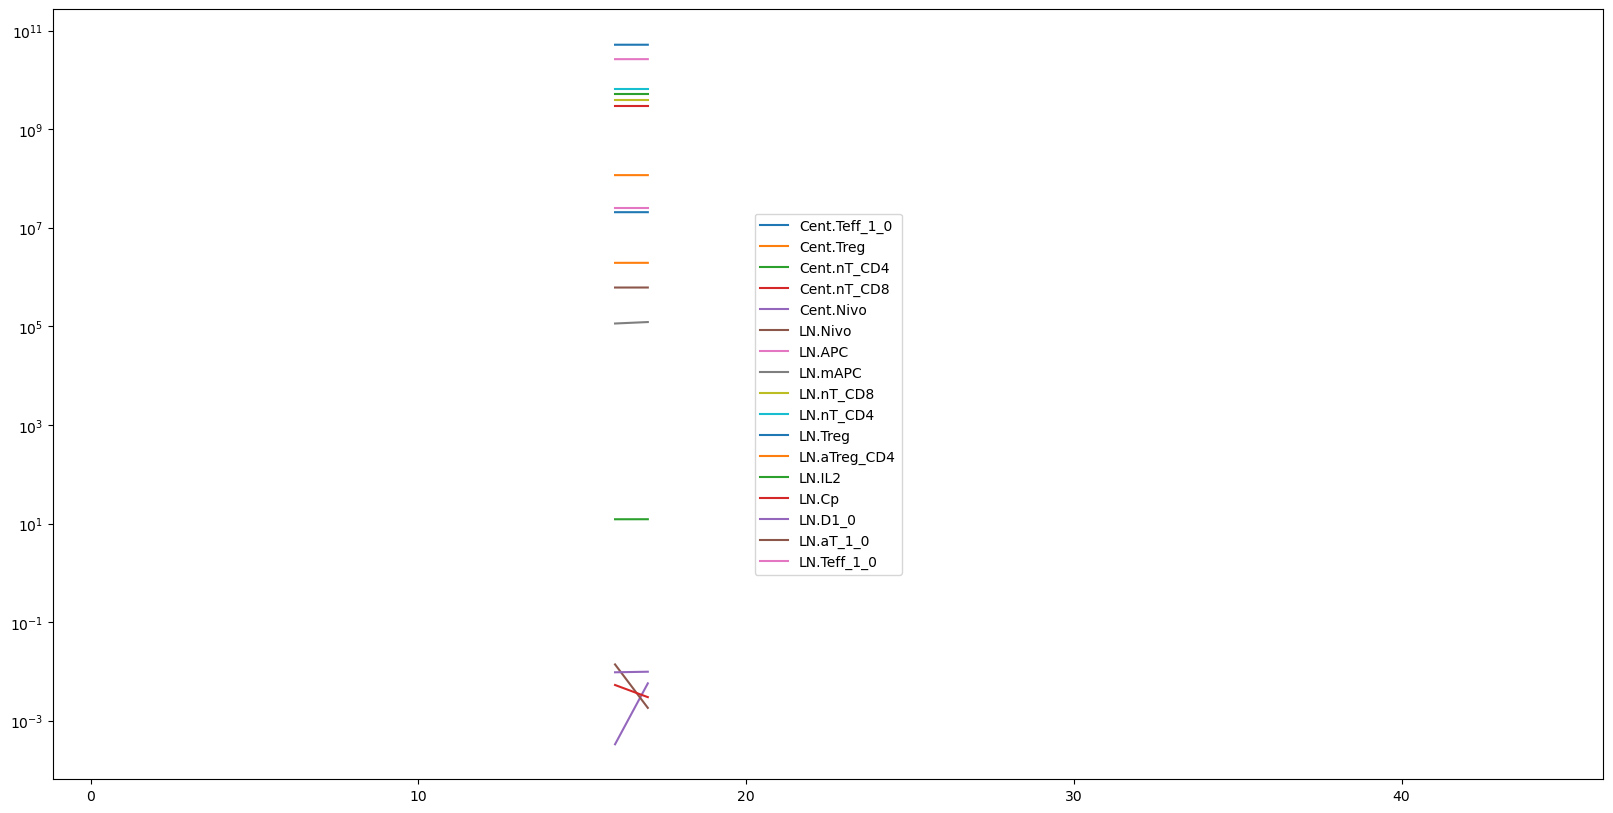

In [16]:
# plot one of the samples with all of the different species, scaled to the same range
plt.figure(figsize=(20, 10))
plt.plot(data[47,:,:])
plt.legend(species_to_keep)
plt.yscale('log')  # Set y-axis to log scale
plt.show()

In [17]:
params_df = pd.read_csv(os.path.join(exp_dir,'param_log.csv'), index_col=0, header=0)

In [18]:
def params_processor(params_df,idx):
		params = params_df.to_numpy()[idx]
		return params

In [19]:
params = params_processor(params_df,data_idx)

In [20]:
params.shape

(5000, 1)

In [21]:
# keep_inliers = (params < 100).squeeze()
# params = params[keep_inliers]
# data = data[keep_inliers,:,:]

In [22]:
validation_ratio = 0.1
split = int(validation_ratio * params.shape[0])
train = {"kd": params[split:], 
					"sim_data": data[split:]}
validation = {"kd": params[:split], 
							"sim_data": data[:split]}   

In [24]:
np.log1p(train['sim_data']).nanstd(axis=0).nanmin()

AttributeError: 'numpy.ndarray' object has no attribute 'nanstd'

In [25]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("sim_data")
	# .constrain(["kd"],lower=0)
    .concatenate(["kd"], into="inference_variables")
    # .rename("prior_draws", "inference_variables")
    .rename("sim_data", "summary_variables")
    # since all our variables are non-negative (zero or larger)
    # this .apply call ensures that the variables are transformed
    # to the unconstrained real space and can be back-transformed under the hood
    .apply(forward=lambda x: np.log1p(x), inverse=lambda x: np.expm1(x))
	# .apply(include=["inference_variables"],forward=lambda x: np.log(x), inverse=lambda x: np.exp(x))
    .standardize(axis=0)
)

In [26]:
adapted_sims = adapter(train)
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

(4500, 53, 17)
(4500, 1)


In [426]:
adapted_sims["inference_variables"].max()

4.519868

In [27]:
np.nanmax(adapted_sims["summary_variables"])

18.01767

In [ ]:
class summary_network(bf.networks.SummaryNetwork):
    def __init__(self, timesteps, features, **kwargs):
        super().__init__(**kwargs)

        self.net = Sequential([
            Input(shape=(timesteps, features)),
            Masking(mask_value=1e20),  # Ignore nan values
            GRU(64, dropout=0.1),
            Dense(8)
])
        
    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

        summary = self.net(time_series)
        return summary

In [29]:
timesteps, features = data.shape[1:]
summary_net = summary_network(timesteps, features)

In [30]:
inference_net = bf.networks.FlowMatching(
    subnet_kwargs={"residual": True, "dropout": 0.1, "widths": (128, 128, 128)}
)

In [31]:
workflow = bf.BasicWorkflow(
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    inference_variables=["kd"]
)

In [32]:
history = workflow.fit_offline(train, epochs=30, batch_size=32, validation_data=validation)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: nan - loss/inference_loss: nan - val_loss: nan - val_loss/inference_loss: nan
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: nan - loss/inference_loss: nan - val_loss: nan - val_loss/inference_loss: nan
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: nan - loss/inference_loss: nan - val_loss: nan - val_loss/inference_loss: nan
Epoch 4/30
 43/141 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: nan - loss/inference_loss: nan

KeyboardInterrupt: 

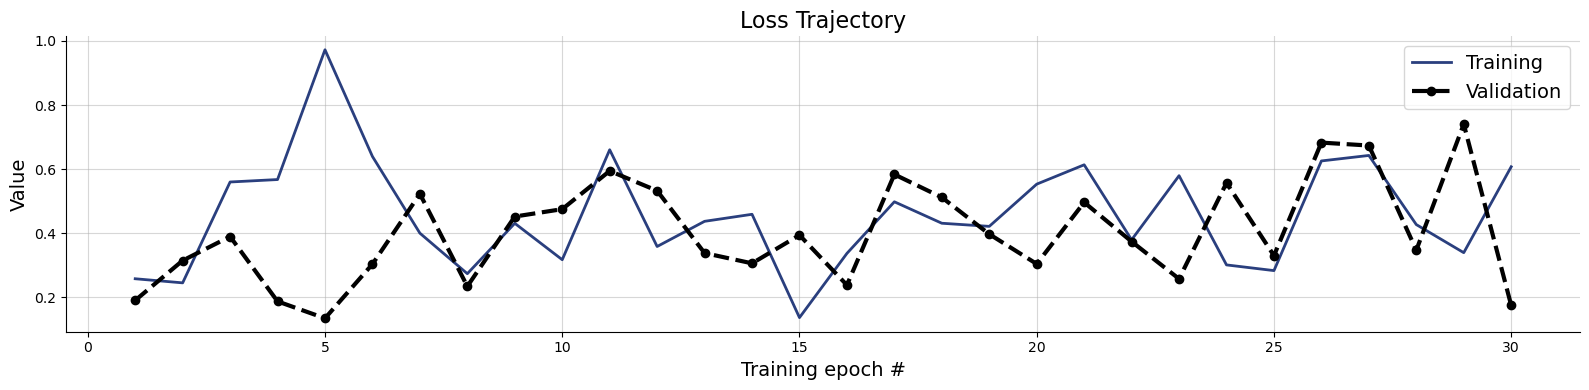

In [387]:
f = bf.diagnostics.plots.loss(history)

In [388]:
# # Set the number of posterior draws you want to get
# num_samples = 1000
num_test_samples = 500
test_idx = list(range(num_samples, num_samples + num_test_samples))

test_qsp_paths = [os.path.join(exp_dir, 'qsp_arr_' + str(i + 1) + '.npz') for i in test_idx]


In [389]:

test_observables = [np.load(path)['arr_0'] for path in test_qsp_paths]
test_observables = np.concatenate(test_observables, axis=0)
test_observables = observables_processor(test_observables)
test_params = params_processor(params_df,test_idx)

test_sims = {"kd": test_params, 
					"sim_data": test_observables}


time_series = test_sims.pop("sim_data")
num_posterior_samples = 500
samples = workflow.sample(conditions={"sim_data": time_series}, num_samples=num_posterior_samples)

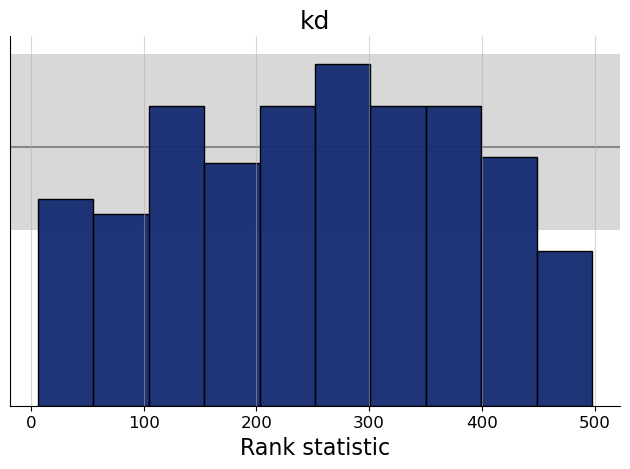

In [390]:
f = bf.diagnostics.plots.calibration_histogram(samples,test_sims)

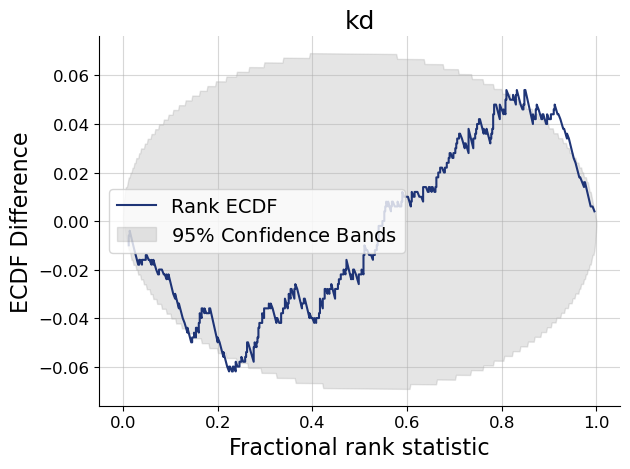

In [391]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True)

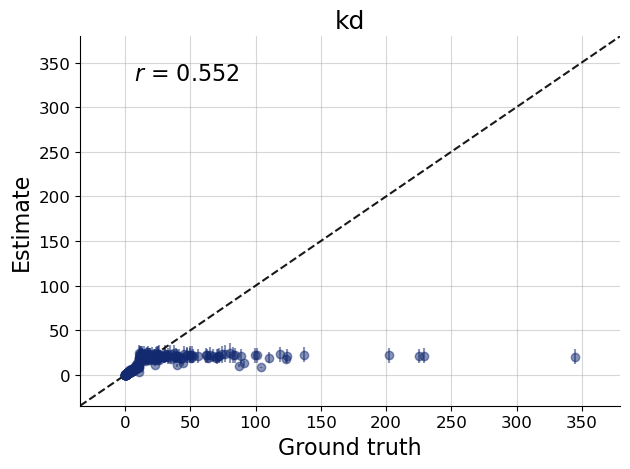

In [392]:
f = bf.diagnostics.plots.recovery(samples, test_sims)

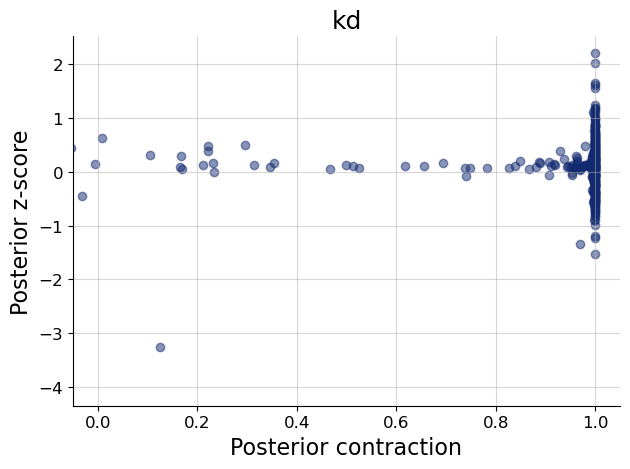

In [393]:
f = bf.diagnostics.plots.z_score_contraction(samples, test_sims)